# Explore and validate dataset

In [1]:
INPUT_DIR='../../input/'

In [2]:
COLOR_RED = (255,0,0)
COLOR_MAGENTA = (250,10,250)
COLOR_BROWN = (84,42,0)
COLOR_BLUE = (30,60,180)
COLOR_GREEN = (35,180,20)

In [3]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import modules.utils as utils

## Segment dots on a test image

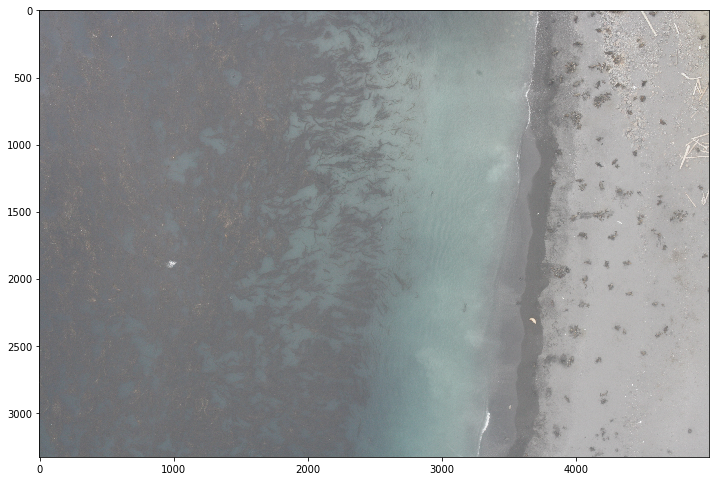

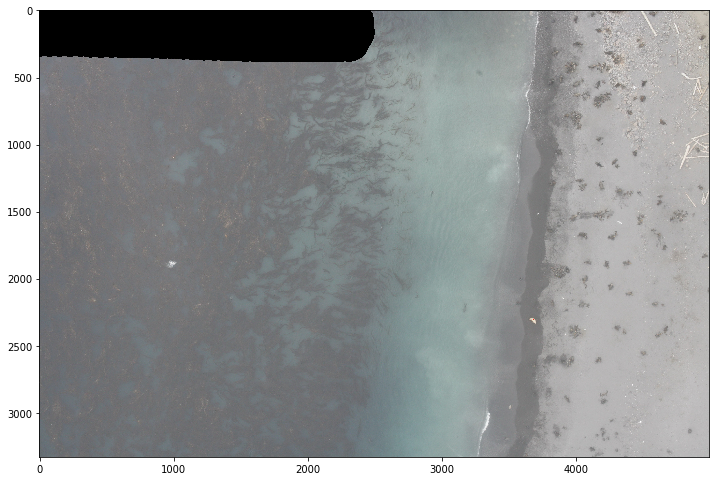

In [4]:
IMAGE_ID = 50

image_raw_file = INPUT_DIR + 'Train/'+ str(IMAGE_ID) +'.jpg'
image_dotted_file = INPUT_DIR + 'TrainDotted/'+ str(IMAGE_ID) +'.jpg'

#bgr
# image_raw = cv2.imread(image_raw_file)[500:3100,2100:3800]
# image_dotted = cv2.imread(image_dotted_file)[500:3100,2100:3800]
image_raw = cv2.imread(image_raw_file)
image_dotted = cv2.imread(image_dotted_file)
utils.show_image(image_raw, is_bgr=True, size=12)
utils.show_image(image_dotted, is_bgr=True, size=12)

#### Remove blacked out regions from raw image

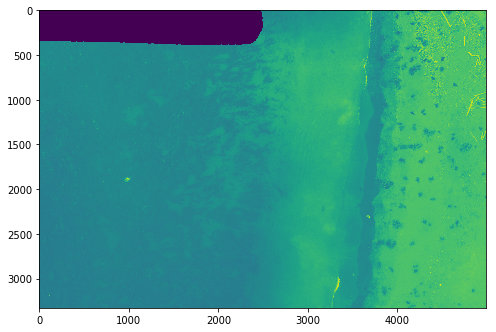

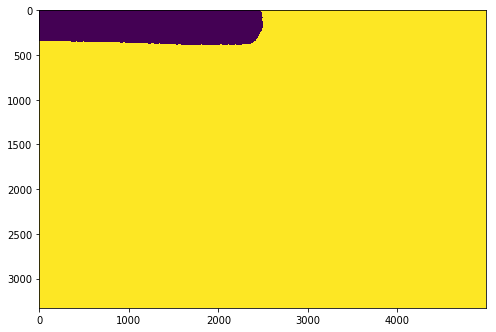

[[  0   0   0 ..., 255 255 255]
 [  0   0   0 ..., 255 255 255]
 [  0   0   0 ..., 255 255 255]
 ..., 
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]]


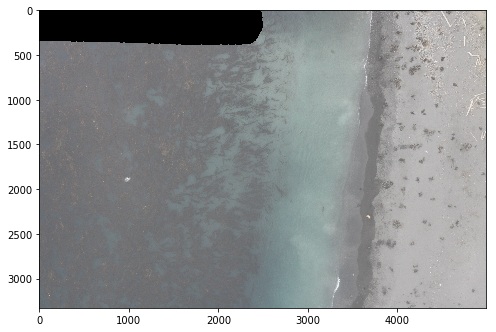

In [5]:
image_dotted_bw = cv2.cvtColor(image_dotted, cv2.COLOR_BGR2GRAY)
utils.show_image(image_dotted_bw, size=8)

mask = cv2.threshold(image_dotted_bw, 5, 255, cv2.THRESH_BINARY)[1]
utils.show_image(mask, size=8)
print(mask)

image_raw_bw = cv2.cvtColor(image_raw, cv2.COLOR_BGR2GRAY)
image_raw = cv2.bitwise_and(image_raw, image_raw, mask=mask)
utils.show_image(image_raw, size=8, is_bgr=True)

#### Detect marked keypoints

In [6]:
#bgr
color_min = {"adult_males": np.array([0, 0, 160]),
           "subadult_male": np.array([200, 0, 200]),
           "adult_females": np.array([10, 40, 75]),
           "juveniles": np.array([150, 40, 0]),
           "pups": np.array([25, 140, 40])
           }

color_max = {"adult_males": np.array([50, 50, 255]),
           "subadult_male": np.array([255, 55, 255]),
           "adult_females": np.array([20, 55, 130]),
           "juveniles": np.array([255, 80, 40]),
           "pups": np.array([50, 255, 65])
           }

def find_class(image, point, classes = ['adult_males', 'subadult_male', 'adult_females', 'juveniles', 'pups']):
    image = image[point[1]-3:point[1]+3,point[0]-3:point[0]+3]
    result = 'none'
    max = 0
    for col in classes:
        cmsk = cv2.inRange(image, color_min[col], color_max[col])
        sm = np.sum(cmsk)
        if(sm>max):
            max = sm
            result = col
    return result

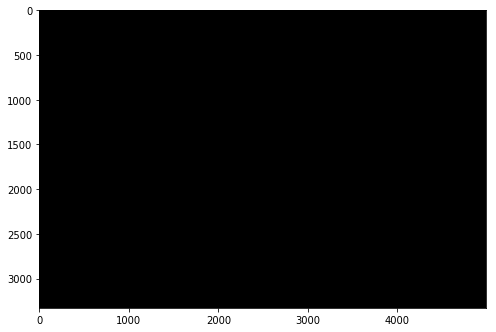

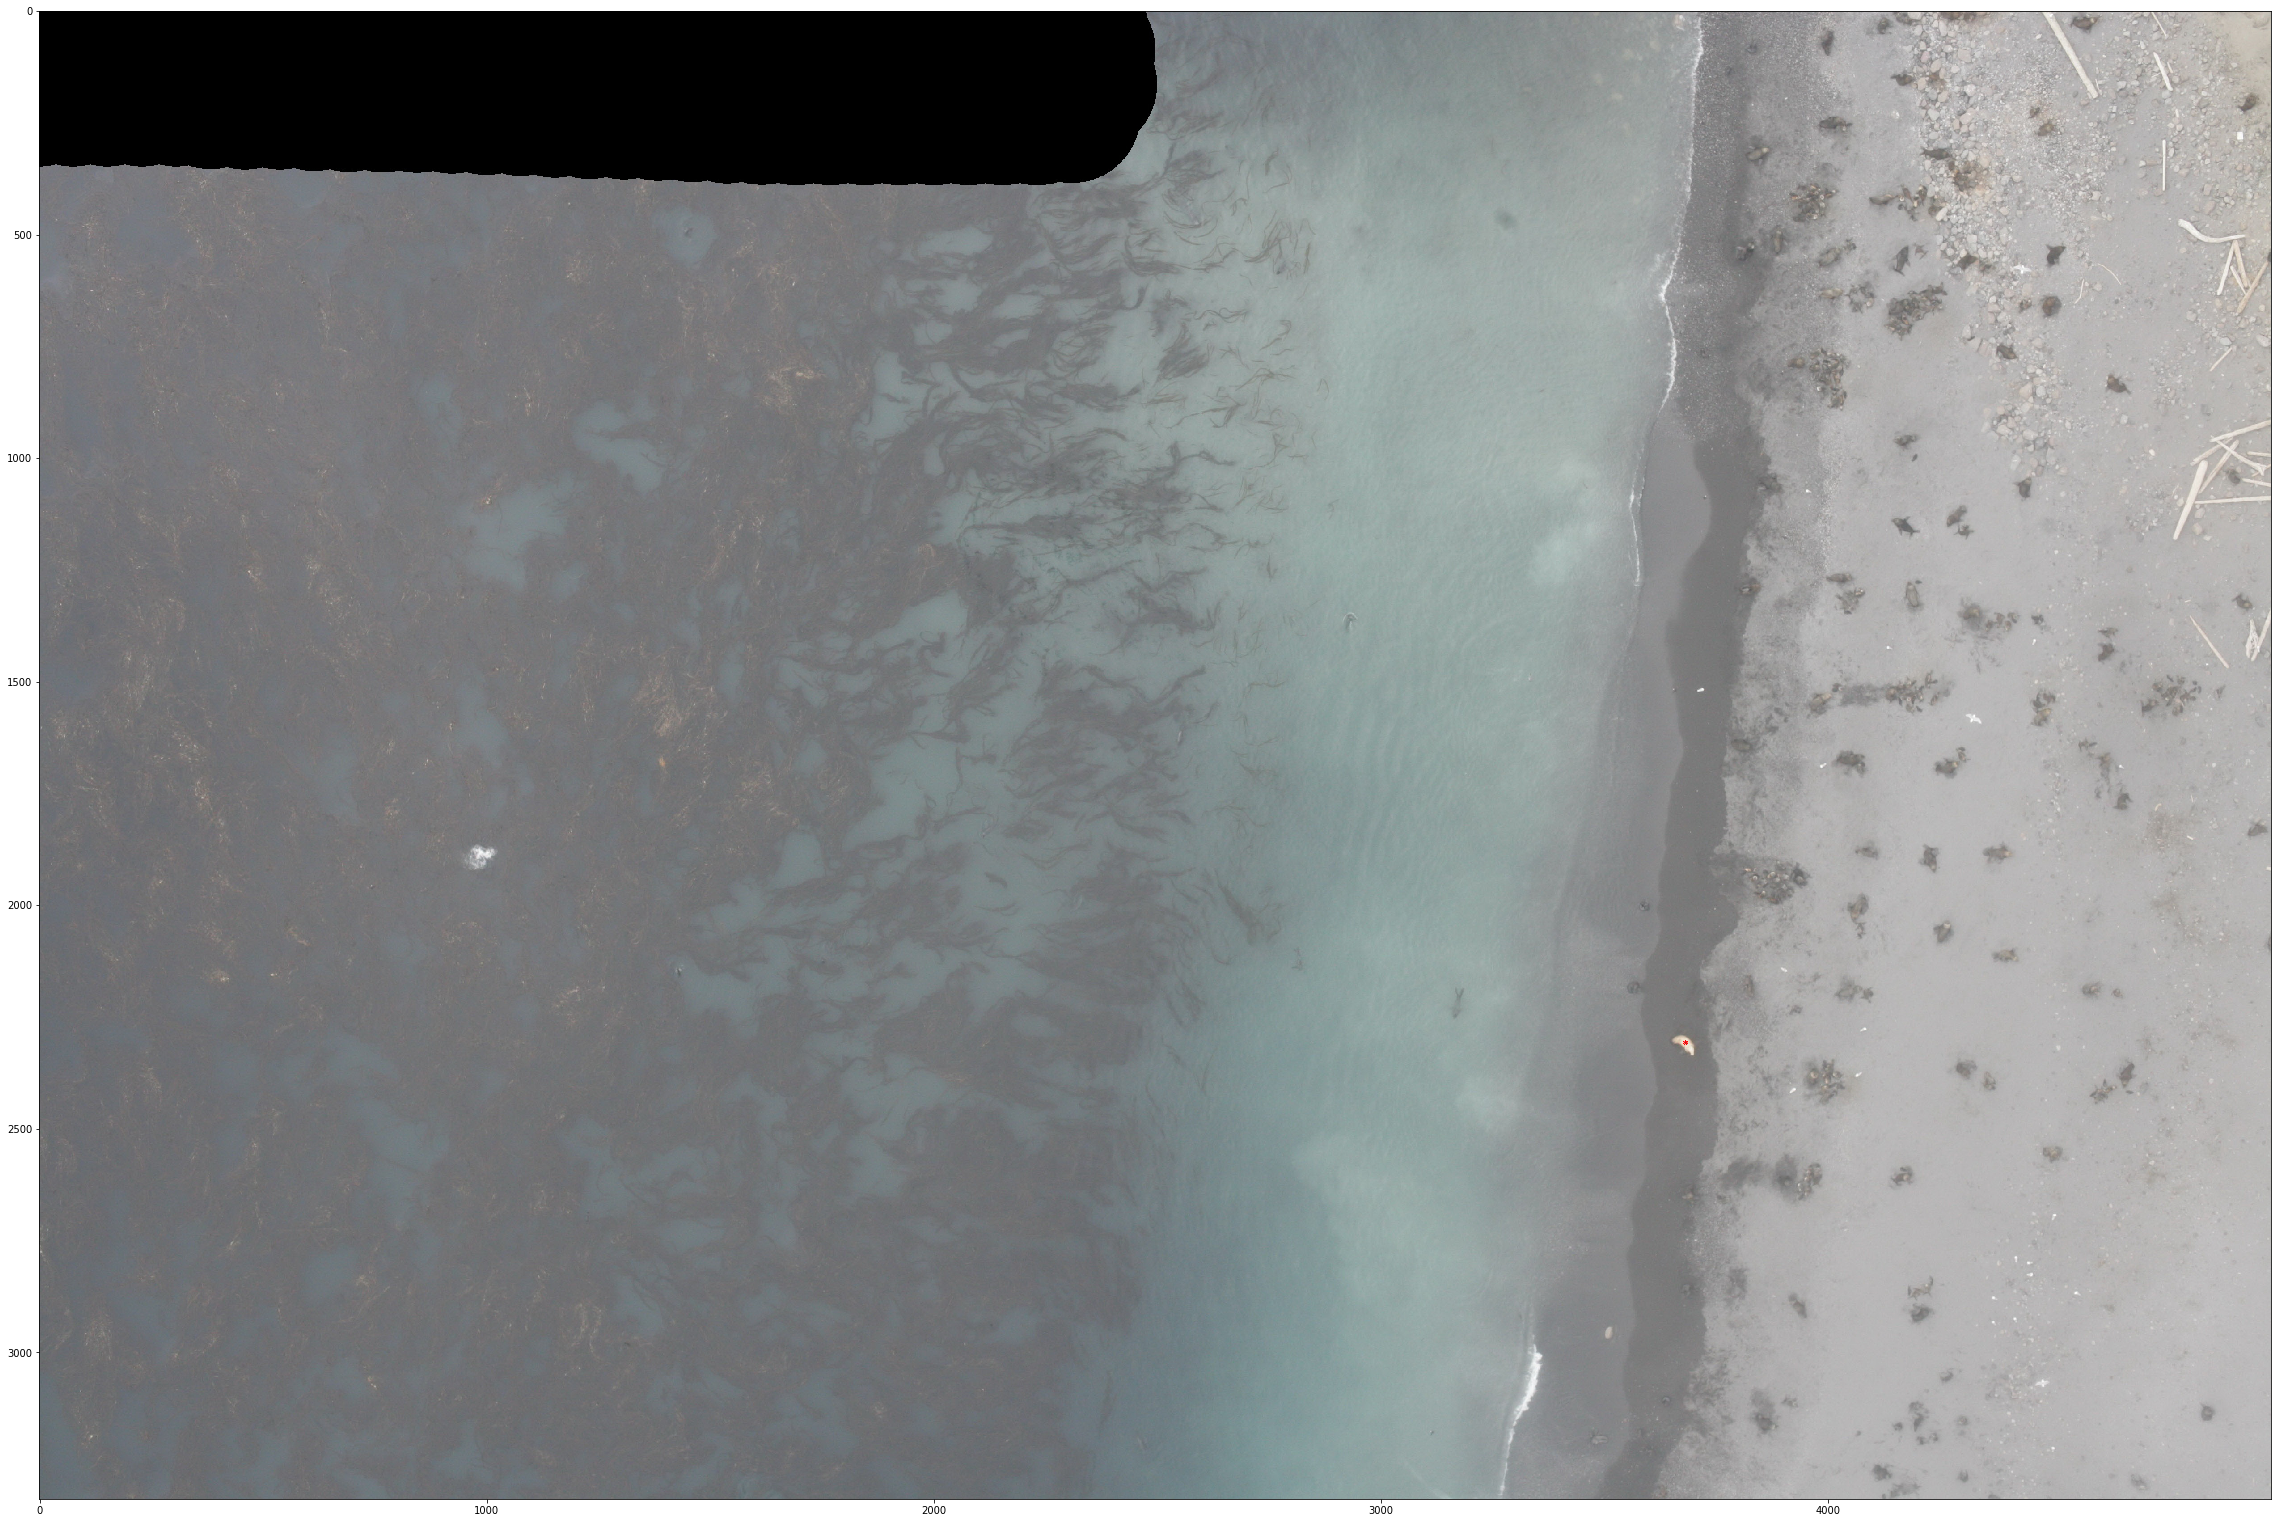

actual count: 1
adult_females = 0
adult_males = 1
none = 0
juveniles = 0
subadult_male = 0
pups = 0
----
expected count: 1
train_id          50
adult_males        1
subadult_males     0
adult_females      0
juveniles          0
pups               0
Name: 50, dtype: int64


In [7]:
diff_color = cv2.absdiff(image_dotted, image_raw)
diff = cv2.cvtColor(diff_color, cv2.COLOR_BGR2GRAY)

kernel = np.ones((2,2),np.uint8)
diff = cv2.morphologyEx(diff, cv2.MORPH_OPEN, kernel)
ret,diff = cv2.threshold(diff,10,255,cv2.THRESH_TOZERO)
ret,diff = cv2.threshold(diff,0,255,cv2.THRESH_BINARY)

count = 0
count_class = {'none':0,'adult_males':0,'subadult_male':0,'adult_females':0,'juveniles':0,'pups':0}
v = image_dotted.copy()
im2, contours, hierarchy = cv2.findContours(diff, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
for c in contours:
    x,y,w,h = cv2.boundingRect(c)
    if(w>4 and h>4):
        center = (x+round(w/3),y+round(h/3))
        cv2.circle(v,center,round(w/2),(0,0,255),1)
        count = count + 1
        clazz = find_class(image_dotted, center)
        count_class[clazz] = count_class[clazz] + 1

utils.show_image(diff, size=8, cmap='gray')
utils.show_image(v, size=40, is_bgr=True)

print('actual count:', count)
for c,v in count_class.items():
    print(c + ' = ' + str(v))

print('----')
train = pd.read_csv(INPUT_DIR + "Train/train.csv")
print('expected count:', train.loc[IMAGE_ID,:].sum(axis=0)-IMAGE_ID)
print(train.loc[IMAGE_ID,:])